# Notebook version of QAOA

In [1]:
# pip install pandas

from qsharp_widgets import EstimatesOverview

In [2]:
# This Notebook acts as a host for Q# to implement Quantum Approximate Optimization Algorithm (QAOA) on a gate-based Quantum Computing model.

# Importing required libraries
# General imports
import time
from numpy import pi
import numpy as np
import matplotlib.pyplot as plt

# Libraries for Model Formulation
from docplex.mp.model import Model
from scipy.optimize import minimize

# Qiskit Imports
from qiskit_optimization.converters import QuadraticProgramToQubo
from qiskit_optimization.translators import from_docplex_mp

# Qsharp
import qsharp

In [3]:
# Defining helper functions.
def find_most_common_solutions(input_dict, n):
    """
    Sorts the keys of the input dictionary in descending order based on their values and returns the first n keys.

    Parameters:
        input_dict (dict): A dictionary containing the keys and their corresponding values.
        n (int): The number of most common solutions to return.

    Returns:
        list: A list of the n most common keys sorted in descending order based on their values.
    """
    sorted_keys = sorted(input_dict, key=input_dict.get, reverse=True)
    return sorted_keys[:n]


# Building the model and its Cost Function
def build_qubo(arr: list):
    """
    Function to build a QUBO (Quadratic Unconstrained Binary Optimization) model from a given array
    for the Number Partitioning Problem (NPP).

    :param arr: a list of integers representing the array from which the QUBO model is built
    :return: a tuple containing the quadratic coefficients, linear coefficients, and the QUBO model
    """

    # Length of the array - Length of the binary vector x
    n = len(arr)
    # Sum of the array - c
    c = sum(arr)

    # Building the model and its QUBO formulation.
    model = Model()
    x = model.binary_var_list(n)

    # Cost Function for Number Partirioning Problem (NPP)
    Q =  (c - 2*sum(arr[i]*x[i] for i in range(n)))**2
    model.minimize(Q)   
    problem = from_docplex_mp(model)

    # QUBO formulation
    converter = QuadraticProgramToQubo()
    qubo = converter.convert(problem)

    # Quadratic and Linear Coefficients
    quadratics = qubo.objective.quadratic.coefficients
    linears = qubo.objective.linear.coefficients

    return quadratics, linears, qubo

def interger_to_counts(n: int, result: list) -> dict:
    """
    Given a list of integers (output of the circuit), returns a dictionary with the counts of each integer.

    Args:
        n (int): The number of qubits in the circuit. Width of the bitstring.
        a (list): The integer array to be converted.

    Returns:
        dict: A dictionary representing the counts of the integers (bitstrings).

    Example:
        >>> interger_to_counts(2 ,[1, 2, 3, 2, 1, 0])
        {'00': 1, '01': 2, '10': 1, '11': 0}
    """
    counts = {}
    for i in range(2**n):
        counts[np.binary_repr(i,width=n)] = 0
    for integer in result:
        counts[np.binary_repr(integer,width=n)] += 1
    return counts

def arr_to_str(a: np.ndarray) -> str:
    """
    Converts a given array to a string representation.

    Args:
        a (list): The array to be converted.

    Returns:
        str: The string representation of the array.

    Example:
        >>> arr_to_str([1, 2, 3])
        '[1, 2, 3]'
    """
    string =''
    for i in a:
        string += str(i) + ","
    return '[' + string[:-1] + ']'

In [4]:
%%qsharp
// This is a program for simulating the QAOA circuit. 
namespace qaoa_note {

    open Microsoft.Quantum.Measurement;

    // Function for getting flat index
    operation flat_index(n: Int, i: Int, j: Int): Int {
        return n * i + j;
    }

    // Cost Hamiltonian
    operation cost_unitary(qubits: Qubit[], gamma: Double, quadratics: Double[], linears: Double[]): Unit {
        
        let n_qubits = Length(linears);
        mutable quad_sum : Double = 0.0;

        // RZ Gates
        for qubit in 0..n_qubits-1 {
            set quad_sum = 0.0;
            for quad_qubit in 0..n_qubits-1 {
                set quad_sum += quadratics[flat_index(n_qubits,qubit,quad_qubit)];
            }
            Rz(0.5 * (linears[qubit] + quad_sum) * gamma, qubits[qubit]);
        }
        // RZZ Gates
        for i in 0..n_qubits-1 {
            for j in i+1..n_qubits-1 {                
                Rzz(0.25 * quadratics[flat_index(n_qubits,i,j)] * gamma, qubits[i], qubits[j]);
            }
        }
    }

    // Mixer Hamiltonian
    operation mixer_unitary(qubits: Qubit[], beta: Double) : Unit {
        for qubit in qubits {
            Rx(2.0 * beta, qubit);
        }
    }

    // Function to create the QAOA circuit
    operation circuit(NQubits: Int, Layers: Int, gammas: Double[], betas: Double[], quadratics: Double[], linears: Double[]) : Int {
        use q = Qubit[NQubits]; 
        mutable integer_result = 0;
        
        // State Preparation |+>
        ApplyToEachA(H,q);

        for layer in 0..Layers-1 {
            mixer_unitary(q, betas[layer]);
            cost_unitary(q, gammas[layer], quadratics, linears);
        }
        // Return the bitstring as an integer.
        return MeasureInteger(q);
    }
}


In [5]:
func_call = 0
theta = []
cost = []

def callback_func(x):
    theta.append(x)

def qaoa_NPP(arr,layers:int):
    
    quadratics, linears, qubo = build_qubo(arr)
    num_qubits = len(arr)

    quadratics = quadratics.toarray().flatten()
    linears = linears.toarray()

    # Initial guess
    init_gamma = np.array([pi/1.5]*layers)
    init_beta = np.array([pi/4]*layers)
    initial_guess = np.concatenate((init_gamma, init_beta))
    
    def expectation_value(theta):
        global func_call 
        func_call = func_call + 1
        print(f'Function call: {func_call}')
        middle = int(len(theta)/2)
        gammas = theta[:middle]
        betas = theta[middle:]

        input_str = f"{num_qubits},{layers},{arr_to_str(gammas)},{arr_to_str(betas)},{arr_to_str(quadratics)},{arr_to_str(linears[0])}"

        int_results = qsharp.run(f"qaoa_note.circuit({input_str})",shots=100)
        counts = interger_to_counts(num_qubits,int_results)

        best_sol = max(counts, key=counts.get) # type: ignore
        exp =  qubo.objective.evaluate(np.array(list(best_sol), dtype='int'))
        cost.append(exp)
        return exp

    # Minimization of the objective function.
    start_time = time.time()
    res = minimize(expectation_value, initial_guess, method='COBYLA',callback=callback_func)
    end_time = time.time()
    elapsed_time = end_time - start_time

    print(f'Elapsed time for QAOA: {elapsed_time} seconds')

    middle = int(len(res.x)/2)
    prime_gammas = res.x[:middle]
    prime_betas = res.x[middle:]

    input_str = f"{num_qubits},{layers},{arr_to_str(prime_gammas)},{arr_to_str(prime_betas)},{arr_to_str(quadratics)},{arr_to_str(linears[0])}"

    results = qsharp.run(f"qaoa_note.circuit({input_str})",shots=100)
    
    counts = interger_to_counts(num_qubits,results)
    
    return counts

# Defining a test array
test_array = [5,1,6]
layers = 2

# Running QAOA on for Number Partitioning.
counts = qaoa_NPP(test_array,layers)

Function call: 1
Function call: 2
Function call: 3
Function call: 4
Function call: 5
Function call: 6
Function call: 7
Function call: 8
Function call: 9
Function call: 10
Function call: 11
Function call: 12
Function call: 13
Function call: 14
Function call: 15
Function call: 16
Function call: 17
Function call: 18
Function call: 19
Function call: 20
Function call: 21
Function call: 22
Function call: 23
Function call: 24
Function call: 25
Function call: 26
Function call: 27
Function call: 28
Function call: 29
Function call: 30
Function call: 31
Function call: 32
Function call: 33
Function call: 34
Function call: 35
Function call: 36
Function call: 37
Function call: 38
Function call: 39
Function call: 40
Function call: 41
Function call: 42
Function call: 43
Function call: 44
Function call: 45
Function call: 46
Elapsed time for QAOA: 23.070911169052124 seconds


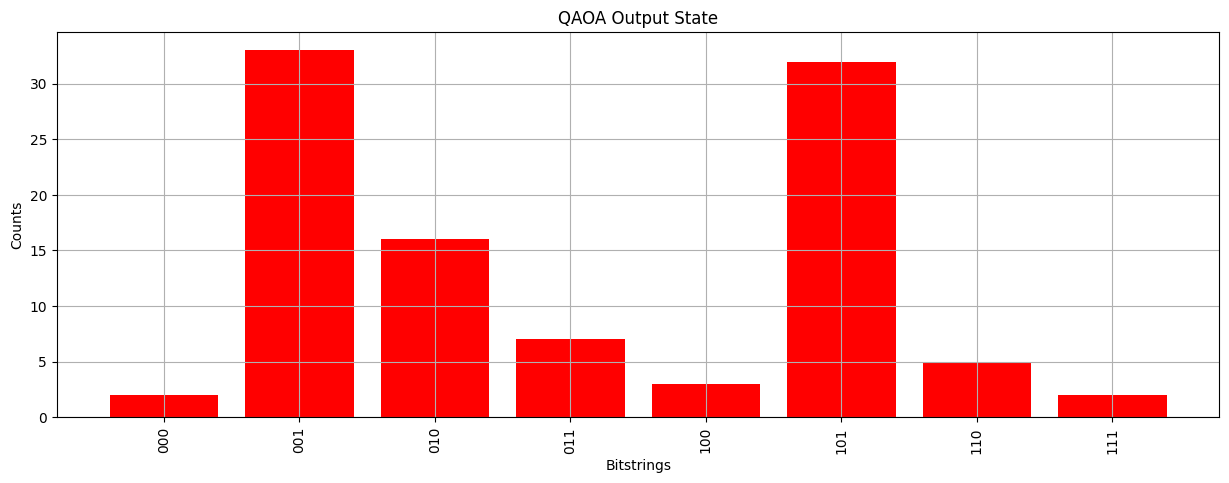

In [6]:
# Plotting the output state.
plt.figure(figsize=(15, 5))
plt.bar(range(len(counts)), list(counts.values()), align='center', color='red')
plt.xticks(range(len(counts)), list(counts.keys()), rotation=90)
plt.title("QAOA Output State")
plt.xlabel("Bitstrings")
plt.ylabel("Counts")
plt.grid()
plt.show()

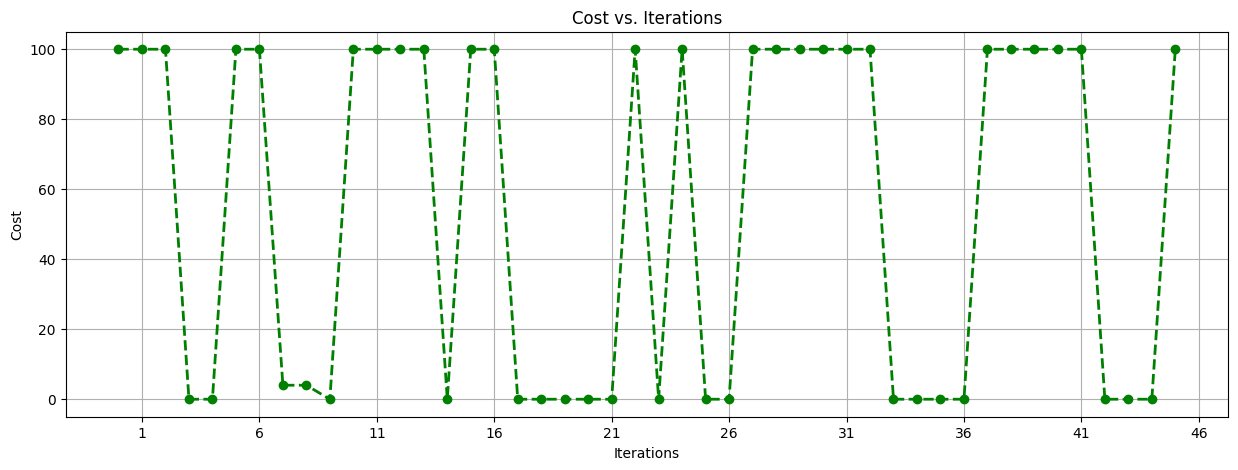

In [7]:
# Plotting Cost vs. iterations.
plt.figure(figsize=(15, 5))
plt.plot(range(len(cost)),cost,color='g',ls='--',marker='o',lw=2)
plt.xticks(range(1,len(cost)+1,5))
plt.title('Cost vs. Iterations')
plt.xlabel('Iterations')
plt.ylabel('Cost')
plt.grid()
plt.show()

In [8]:
best_sol = find_most_common_solutions(counts,3)
print(f'\nQAOA Top 3 solutions for {test_array} and {layers} layers: \n{best_sol}')

c = sum(test_array)
S = []
S_A = []
for ind,bit in enumerate(best_sol[0]):
    if bit == '1':
        S.append(ind)
    else:
        S_A.append(ind)

sum_S = sum(np.array(test_array)[S])
sum_S_A = sum(np.array(test_array)[S_A])    

print(f'\n\n Best partition:\nS {np.array(test_array)[S]} - Sum(S) = {sum_S}\nS/A {np.array(test_array)[S_A]} - Sum(S/A) = {sum_S_A}')


QAOA Top 3 solutions for [5, 1, 6] and 2 layers: 
['001', '101', '010']


 Best partition:
S [6] - Sum(S) = 6
S/A [5 1] - Sum(S/A) = 6


## Using the Resourse Estimator

In [9]:
test_array = [1,2,4]

n = len(test_array)
layers = 3

quadratics, linears, qubo = build_qubo(test_array)
quadratics = quadratics.toarray().flatten()
linears = linears.toarray()

gammas = np.random.rand(layers)
betas = np.random.rand(layers)

input_str = f"{n},{layers},{arr_to_str(gammas)},{arr_to_str(betas)},{arr_to_str(quadratics)},{arr_to_str(linears[0])}"


In [10]:
#below this cell is the testing and changing of parameters

In [11]:
result_batch = qsharp.estimate(f"qaoa_note.circuit({input_str})", params=
                [{}, # Default parameters
                {
                    "qubitParams": {
                        "name": "qubit_maj_ns_e6"
                    },
                    "qecScheme": {
                        "name": "floquet_code"
                    }
                }])
result_batch.summary_data_frame(labels=["Gate-based ns, 10⁻³", "Majorana ns, 10⁻⁶"])

,Logical qubits,Logical depth,T states,Code distance,T factories,T factory fraction,Physical qubits,rQOPS,Physical runtime
"Gate-based ns, 10⁻³",12,240,378,11,21,98.59 %,206.18k,2.73M,1 millisecs
"Majorana ns, 10⁻⁶",12,240,378,3,25,97.66 %,26.62k,13.33M,216 microsecs


In [15]:
from qsharp.estimator import EstimatorParams, QubitParams, QECScheme

labels = ["Gate-based µs, 10⁻³", "Gate-based µs, 10⁻⁴", "Gate-based ns, 10⁻³", "Gate-based ns, 10⁻⁴", "F-Majorana ns, 10⁻⁴", "F-Majorana ns, 10⁻⁶", "S-Majorana ns, 10⁻⁴", "S-Majorana ns, 10⁻⁶"]

params = EstimatorParams(num_items=8)
params.error_budget = 0.333
params.items[0].qubit_params.name = QubitParams.GATE_US_E3
params.items[1].qubit_params.name = QubitParams.GATE_US_E4
params.items[2].qubit_params.name = QubitParams.GATE_NS_E3
params.items[3].qubit_params.name = QubitParams.GATE_NS_E4
params.items[4].qubit_params.name = QubitParams.MAJ_NS_E4
params.items[4].qec_scheme.name = QECScheme.FLOQUET_CODE
params.items[5].qubit_params.name = QubitParams.MAJ_NS_E6
params.items[5].qec_scheme.name = QECScheme.FLOQUET_CODE
params.items[6].qubit_params.name = QubitParams.MAJ_NS_E4
params.items[6].qec_scheme.name = QECScheme.SURFACE_CODE
params.items[7].qubit_params.name = QubitParams.MAJ_NS_E6
params.items[7].qec_scheme.name = QECScheme.SURFACE_CODE

# results = qsharp.estimate(f"qaoa_note.circuit({input_str})", params=params).summary_data_frame(labels=labels)
results = qsharp.estimate(f"qaoa_note.circuit({input_str})", params=params)
display(results[:])

results = qsharp.estimate(f"qaoa_note.circuit({input_str})", params=params).summary_data_frame(labels=labels)

results[:]

QSharpError: [31mQsc.TypeCk.TyMismatch[0m

  [31m×[0m type error
[31m  ╰─▶ [0mexpected (Int, Int, Double[], Double[], Double[], Double[]), found Int[]
   ╭─[[36;1;4m<entry>[0m:1:1]
 [2m1[0m │ qaoa_note.circuit(([1, 1, 1, 1, 1]))
   · [35;1m────────────────────────────────────[0m
   ╰────


In [13]:
estimates_overview = EstimatesOverview(results)
estimates_overview

TraitError: The 'estimates' trait of an EstimatesOverview instance expected a dict, not the DataFrame                     Logical qubits Logical depth T states  Code distance  \
Gate-based µs, 10⁻³             12           180      270              5   
Gate-based µs, 10⁻⁴             12           180      270              3   
Gate-based ns, 10⁻³             12           180      270              5   
Gate-based ns, 10⁻⁴             12           180      270              3   
F-Majorana ns, 10⁻⁴             12           180      270              3   
F-Majorana ns, 10⁻⁶             12           180      270              1   
S-Majorana ns, 10⁻⁴             12           180      270              5   
S-Majorana ns, 10⁻⁶             12           180      270              3   

                    T factories T factory fraction Physical qubits   rQOPS  \
Gate-based µs, 10⁻³           2            14.29 %             700   4.00k   
Gate-based µs, 10⁻⁴           2            14.29 %             252   6.67k   
Gate-based ns, 10⁻³          20            98.52 %          40.60k   6.00M   
Gate-based ns, 10⁻⁴           2            14.29 %             252  10.00M   
F-Majorana ns, 10⁻⁴          27            99.34 %          94.26k  13.33M   
F-Majorana ns, 10⁻⁶          23            94.52 %             876  40.00M   
S-Majorana ns, 10⁻⁴          21            99.18 %          73.43k   1.20M   
S-Majorana ns, 10⁻⁶           2            25.00 %             288   2.00M   

                    Physical runtime  
Gate-based µs, 10⁻³    540 millisecs  
Gate-based µs, 10⁻⁴    324 millisecs  
Gate-based ns, 10⁻³    360 microsecs  
Gate-based ns, 10⁻⁴    216 microsecs  
F-Majorana ns, 10⁻⁴    162 microsecs  
F-Majorana ns, 10⁻⁶     54 microsecs  
S-Majorana ns, 10⁻⁴      2 millisecs  
S-Majorana ns, 10⁻⁶      1 millisecs  .

In [ ]:

result = qsharp.estimate(f"qaoa_note.circuit({input_str})", params={"errorBudget": 0.01, "qubitParams": {"name": "qubit_maj_ns_e6"}, "qecScheme": {"name": "floquet_code"},"estimateType": "frontier", "constraints": {"logicalDepthFactor": 4}})

estimates_overview = EstimatesOverview(result)
estimates_overview

EstimatesOverview(estimates={'status': 'success', 'jobParams': {'qecScheme': {'name': 'floquet_code', 'errorCo…

In [ ]:
estimates_overview = EstimatesOverview(result)
estimates_overview

EstimatesOverview(estimates={'status': 'success', 'jobParams': {'qecScheme': {'name': 'floquet_code', 'errorCo…

In [ ]:
import pandas as pd

# Define the runNames
runNames = [
    "Gate-based µs, 10⁻³", "Gate-based µs, 10⁻⁴",
    "Gate-based ns, 10⁻³", "Gate-based ns, 10⁻⁴",
    "S-Majorana ns, 10⁻⁴", "F-Majorana ns, 10⁻⁴",
    "S-Majorana ns, 10⁻⁶", "F-Majorana ns, 10⁻⁶"
]

# Generate error budget values from 0.001 to 0.331
error_budget_values = [0.001 + i * 0.01 for i in range(34)]

# List to store DataFrames for each error budget
data_frames = []

for error_budget in error_budget_values:
    # Assuming qsharp is properly imported elsewhere in your code
    result = qsharp.estimate(
        f"qaoa_note.circuit({input_str})", 
        params=[
            {
                "errorBudget": error_budget,
                "qubitParams": { "name": "qubit_gate_ns_e3" },
                "qecScheme": { "name": "surface_code" }
            },
            {
                "errorBudget": error_budget,
                "qubitParams": { "name": "qubit_gate_ns_e4" },
                "qecScheme": { "name": "surface_code" }
            },
            {
                "errorBudget": error_budget,
                "qubitParams": { "name": "qubit_gate_us_e3" },
                "qecScheme": { "name": "surface_code" }
            },
            {
                "errorBudget": error_budget,
                "qubitParams": { "name": "qubit_gate_us_e4" },
                "qecScheme": { "name": "surface_code" }
            },
            {
                "errorBudget": error_budget,
                "qubitParams": { "name": "qubit_maj_ns_e4" },
                "qecScheme": { "name": "surface_code" }
            },
            {
                "errorBudget": error_budget,
                "qubitParams": { "name": "qubit_maj_ns_e4" },
                "qecScheme": { "name": "floquet_code" }
            },
            {
                "errorBudget": error_budget,
                "qubitParams": { "name": "qubit_maj_ns_e6" },
                "qecScheme": { "name": "surface_code" }
            },
            {
                "errorBudget": error_budget,
                "qubitParams": { "name": "qubit_maj_ns_e6" },
                "qecScheme": { "name": "floquet_code" }
            }
        ]
    )
    df = result.summary_data_frame()
    df['ErrorBudget'] = error_budget
    df['Circuit Type'] = runNames  # Add the runNames as a column
    data_frames.append(df)

# Concatenate all DataFrames into a single DataFrame
df = pd.concat(data_frames, ignore_index=True)
df



,Logical qubits,Logical depth,T states,Code distance,T factories,T factory fraction,Physical qubits,rQOPS,Physical runtime,ErrorBudget,Circuit Type
0,12,240,378,11,21,98.59 %,206.18k,2.73M,1 millisecs,0.001,"Gate-based µs, 10⁻³"
1,12,240,378,5,21,97.22 %,21.60k,6.00M,480 microsecs,0.001,"Gate-based µs, 10⁻⁴"
2,12,240,378,11,21,97.22 %,104.54k,1.82k,2 secs,0.001,"Gate-based ns, 10⁻³"
3,12,240,378,5,21,97.22 %,21.60k,4.00k,720 millisecs,0.001,"Gate-based ns, 10⁻⁴"
4,12,240,378,9,30,99.69 %,631.94k,666.67k,4 millisecs,0.001,"S-Majorana ns, 10⁻⁴"
...,...,...,...,...,...,...,...,...,...,...,...
267,12,180,270,3,2,14.29 %,252,6.67k,324 millisecs,0.331,"Gate-based ns, 10⁻⁴"
268,12,180,270,5,21,99.18 %,73.43k,1.20M,2 millisecs,0.331,"S-Majorana ns, 10⁻⁴"
269,12,180,270,3,27,99.34 %,94.26k,13.33M,162 microsecs,0.331,"F-Majorana ns, 10⁻⁴"
270,12,180,270,3,2,25.00 %,288,2.00M,1 millisecs,0.331,"S-Majorana ns, 10⁻⁶"


In [ ]:
# Convert Physical runtime values to numbers
def convert_runtime(time_str):
    if " secs" in time_str:
        return float(time_str.split()[0]) * 1
    elif "millisecs" in time_str:
        return float(time_str.split()[0]) * 1e-3
    elif "microsecs" in time_str:
        return float(time_str.split()[0]) * 1e-4

df["Physical runtime"] = df["Physical runtime"].apply(convert_runtime)

# Convert Factory Fraction values to numbers
def convert_T_factory_fraction(fraction_str):
    return float(fraction_str.strip("%")) / 100

df["T factory fraction"] = df["T factory fraction"].apply(convert_T_factory_fraction)

# Convert Physical qubits values to numbers
def convert_physical_qubits(qubits_str):
    if "k" in qubits_str:
        return float(qubits_str.strip("k")) * 1000
    else:
        return float(qubits_str)

df["Physical qubits"] = df["Physical qubits"].apply(convert_physical_qubits)

# Convert T factories values to numbers
def convert_T_factories(value_str):
    return float(value_str)

df["T factories"] = df["T factories"].apply(convert_T_factories)

# Convert code distance values to numbers
def convert_Code_distance(value_str):
    return float(value_str)

df["Code distance"] = df["Code distance"].apply(convert_Code_distance)

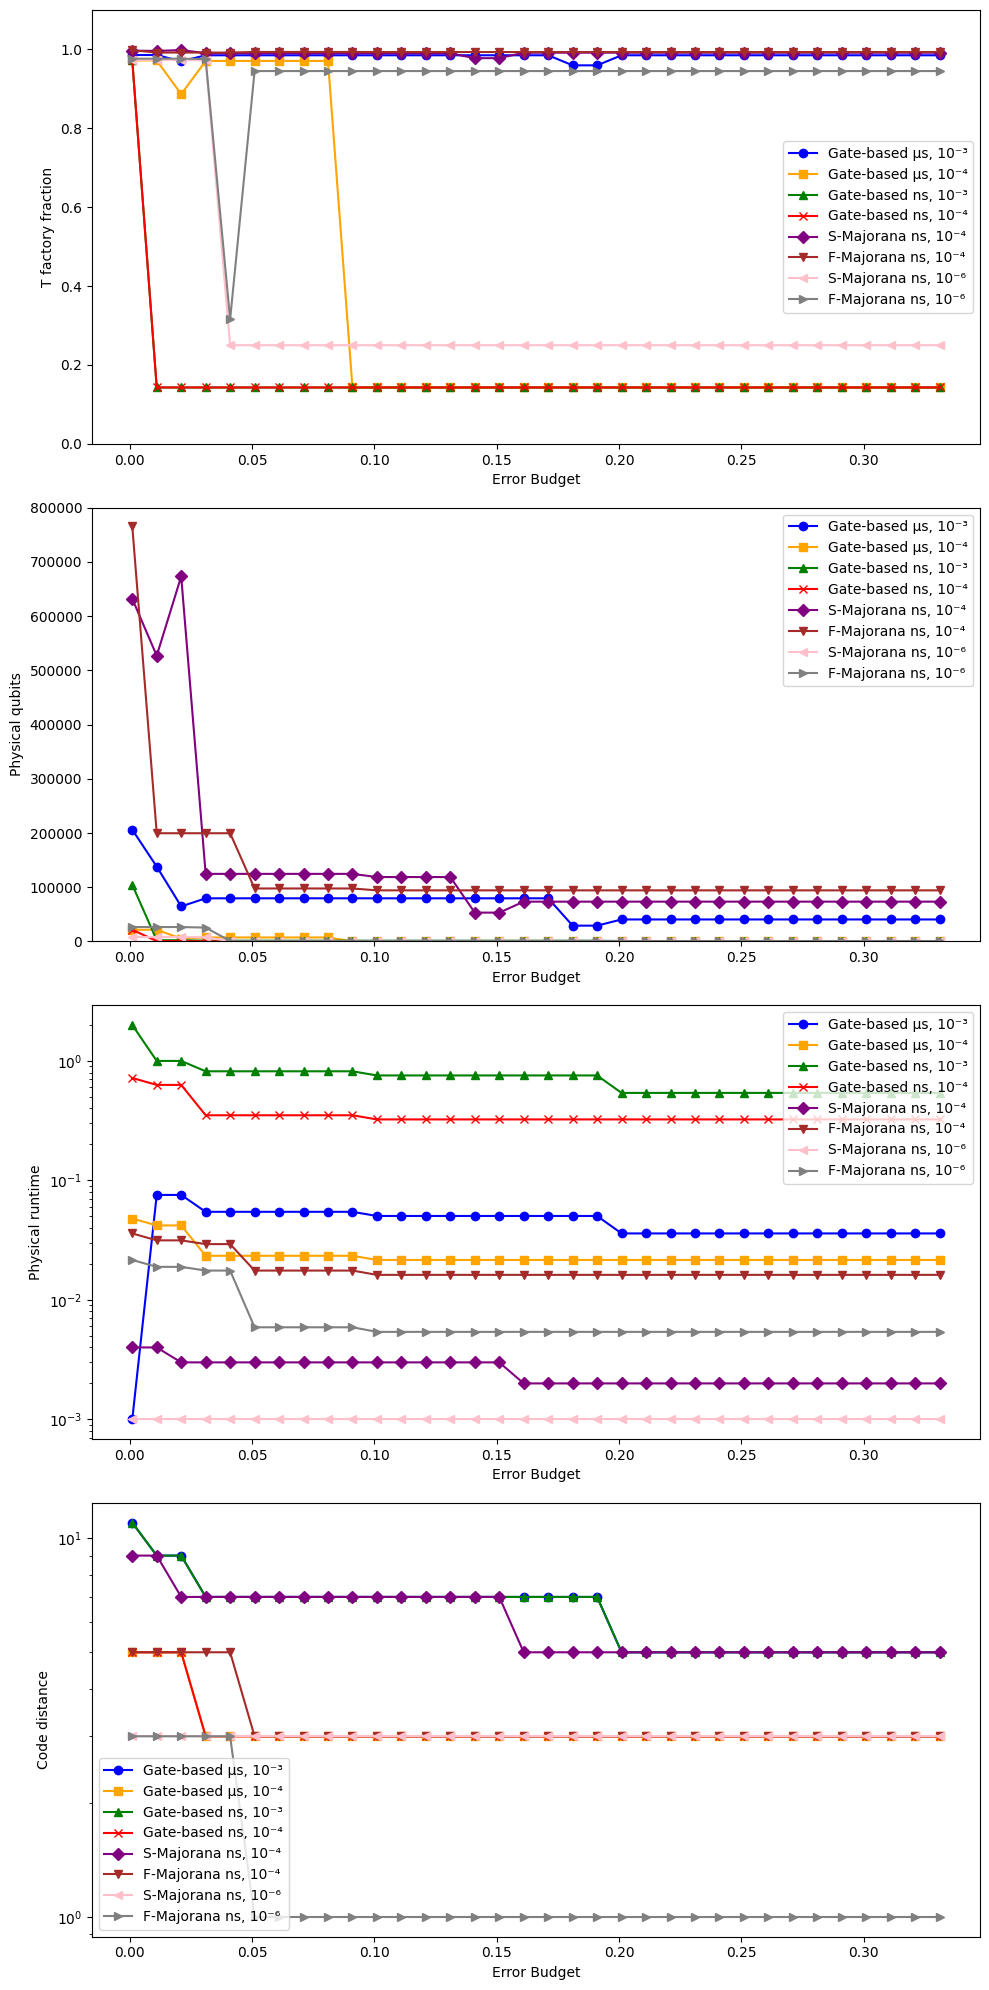

In [ ]:
import matplotlib.pyplot as plt

# Create a figure and axis objects
fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(10, 20))

# Define marker styles and colors for different circuit types
marker_styles = ['o', 's', '^', 'x', 'D', 'v', '<', '>']
colors = ['blue', 'orange', 'green', 'red', 'purple', 'brown', 'pink', 'gray']

# Plot each metric on its own subplot
for i, metric in enumerate(['T factory fraction', 'Physical qubits', 'Physical runtime', 'Code distance']):
    ax = axes[i]
    if metric == 'T factory fraction':
        ax.set_ylim(0, 1.1)  # Set y-axis limit for T factory fraction
    elif metric == 'Physical qubits':
        ax.set_ylim(0, 800000)  # Set y-axis limit for Physical qubits
    else:
        ax.set_yscale('log')  # Set y-axis to logarithmic scale for other metrics
    for j, runName in enumerate(runNames):
        df_subset = df[df['Circuit Type'] == runName]
        ax.plot(df_subset['ErrorBudget'], df_subset[metric], marker=marker_styles[j], linestyle='-', color=colors[j], label=runName)
    ax.set_xlabel('Error Budget')
    ax.set_ylabel(metric)
    ax.legend()

plt.tight_layout()
plt.show()

In [14]:
import qsharp
from qsharp.estimator import EstimatorParams, QubitParams, QECScheme
import pandas as pd
import matplotlib.pyplot as plt

# Define the error budget (fixed at a certain point)
error_budget = 0.05

# Define the number of items in each test array
num_items_lists = [5, 10, 15, 20, 25, 30, 35]

# Define the runNames
runNames = [
    "Gate-based µs, 10⁻³", "Gate-based µs, 10⁻⁴",
    "Gate-based ns, 10⁻³", "Gate-based ns, 10⁻⁴",
    "S-Majorana ns, 10⁻⁴", "F-Majorana ns, 10⁻⁴",
    "S-Majorana ns, 10⁻⁶", "F-Majorana ns, 10⁻⁶"
]

# List to store DataFrames for each error budget
data_frames = []

for num_items in num_items_lists:
    # Generate input string for Q# circuit
    input_str = f"({[1]*num_items})"
    
    # Run Q# estimation for the given input size
    result = qsharp.estimate(
        f"qaoa_note.circuit({input_str})", 
        params=[
            {
                "errorBudget": error_budget,
                "qubitParams": { "name": "qubit_gate_ns_e3" },
                "qecScheme": { "name": "surface_code" }
            },
            {
                "errorBudget": error_budget,
                "qubitParams": { "name": "qubit_gate_ns_e4" },
                "qecScheme": { "name": "surface_code" }
            },
            {
                "errorBudget": error_budget,
                "qubitParams": { "name": "qubit_gate_us_e3" },
                "qecScheme": { "name": "surface_code" }
            },
            {
                "errorBudget": error_budget,
                "qubitParams": { "name": "qubit_gate_us_e4" },
                "qecScheme": { "name": "surface_code" }
            },
            {
                "errorBudget": error_budget,
                "qubitParams": { "name": "qubit_maj_ns_e4" },
                "qecScheme": { "name": "surface_code" }
            },
            {
                "errorBudget": error_budget,
                "qubitParams": { "name": "qubit_maj_ns_e4" },
                "qecScheme": { "name": "floquet_code" }
            },
            {
                "errorBudget": error_budget,
                "qubitParams": { "name": "qubit_maj_ns_e6" },
                "qecScheme": { "name": "surface_code" }
            },
            {
                "errorBudget": error_budget,
                "qubitParams": { "name": "qubit_maj_ns_e6" },
                "qecScheme": { "name": "floquet_code" }
            }
        ]
    )
    df = result.summary_data_frame()
    df['NumItems'] = num_items
    df['Circuit Type'] = runNames  # Add the runNames as a column
    data_frames.append(df)

# Concatenate all DataFrames into a single DataFrame
df = pd.concat(data_frames, ignore_index=True)

# Convert Physical runtime values to numbers
def convert_runtime(time_str):
    if " secs" in time_str:
        return float(time_str.split()[0]) * 1
    elif "millisecs" in time_str:
        return float(time_str.split()[0]) * 1e-3
    elif "microsecs" in time_str:
        return float(time_str.split()[0]) * 1e-4

df["Physical runtime"] = df["Physical runtime"].apply(convert_runtime)

# Plotting
plt.figure(figsize=(10, 6))

for metric in ['T factory fraction', 'Physical runtime', 'Code distance']:
    plt.plot(df['NumItems'], df[metric], marker='o', label=metric)

plt.xlabel('Number of Items')
plt.ylabel('Parameter Value')
plt.title('Parameter Variation with Increasing Input Size')
plt.legend()
plt.grid(True)
plt.show()

QSharpError: [31mQsc.TypeCk.TyMismatch[0m

  [31m×[0m type error
[31m  ╰─▶ [0mexpected (Int, Int, Double[], Double[], Double[], Double[]), found Int[]
   ╭─[[36;1;4m<entry>[0m:1:1]
 [2m1[0m │ qaoa_note.circuit(([1, 1, 1, 1, 1]))
   · [35;1m────────────────────────────────────[0m
   ╰────
